# Jores et al 2021 Sandbox
**Authorship:**
Adam Klie, *08/12/2022*
***
**Description:**
Notebook to for testing Jores et al dataset functionality
***

In [1]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

import os
import glob
import logging
import torch
import numpy as np
import pandas as pd
import eugene as eu
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Global seed set to 13


GPU is available: True
Number of GPUs: 1
Current GPU: 0
GPUs: Quadro RTX 5000


In [2]:
eu.settings.dataset_dir = "/cellar/users/aklie/data/eugene/jores21"
eu.settings.output_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/jores21"
eu.settings.logging_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/logs/jores21"
eu.settings.config_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/configs/jores21"
eu.settings.figure_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/figures/jores21"
eu.settings.verbosity = logging.ERROR
eu.settings.batch_size = 128
eu.settings.dl_num_workers = 0

# Double check files

In [8]:
sdata = eu.dl.read_h5sd(os.path.join(eu.settings.output_dir, f"proto_evolved_sequences.h5sd"))

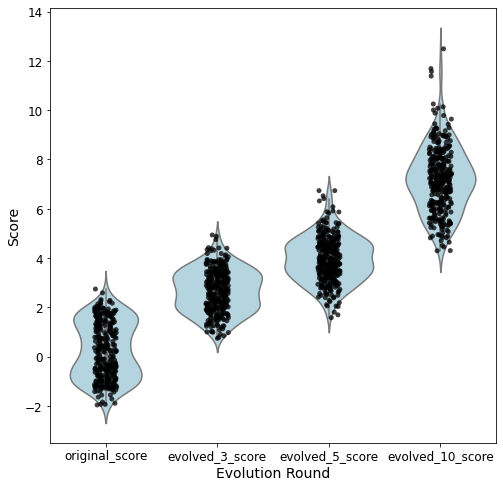

In [10]:
eu.pl.violinplot(
    sdata,
    groupby=["original_score", "evolved_3_score", "evolved_5_score", "evolved_10_score"],
    xlabel="Evolution Round",
    ylabel="Score",
    color = "lightblue",
)

# Fix the in silico evolve function 

In [10]:
# Load dataset
sdata_evolve = eu.dl.read_csv(os.path.join(eu.settings.dataset_dir, "promoters_for_evolution.tsv"), seq_col="sequence", name_col="name")
sdata_evolve = sdata_evolve[:10]

In [114]:
# Load in a trained model
leaf_model_file = glob.glob(os.path.join(eu.settings.logging_dir, "ssHybrid", f"leaf_trial_5", "checkpoints", "*"))[0]
leaf_model = eu.models.Hybrid.load_from_checkpoint(leaf_model_file)
leaf_model

Hybrid(
  (hp_metric): R2Score()
  (convnet): BasicConv1D(
    (module): Sequential(
      (0): Conv1d(4, 256, kernel_size=(13,), stride=(1,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.3, inplace=False)
      (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Conv1d(256, 256, kernel_size=(13,), stride=(1,))
      (6): ReLU()
      (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Dropout(p=0.3, inplace=False)
      (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): Conv1d(256, 256, kernel_size=(13,), stride=(1,))
      (11): ReLU()
      (12): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (13): Dropout(p=0.3, inplace=False)
      (14): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (recurren

In [56]:
evolved_sequence = eu.interpret.evolve_sdata(
    leaf_model,
    sdata_evolve,
    rounds=10,
    return_seqs=True
)

Evolving seqs:   0%|          | 0/10 [00:00<?, ?it/s]

tensor([[[0.6795]]], device='cuda:0')
tensor([[[2.3191]]], device='cuda:0')
tensor([[[2.6086]]], device='cuda:0')
tensor([[[2.8904]]], device='cuda:0')
tensor([[[3.1332]]], device='cuda:0')
tensor([[[3.3656]]], device='cuda:0')
tensor([[[3.5727]]], device='cuda:0')
tensor([[[3.7453]]], device='cuda:0')
tensor([[[3.8808]]], device='cuda:0')
tensor([[[3.9904]]], device='cuda:0')
tensor([[[3.4167]]], device='cuda:0')
tensor([[[3.8561]]], device='cuda:0')
tensor([[[4.0901]]], device='cuda:0')
tensor([[[4.1885]]], device='cuda:0')
tensor([[[4.2700]]], device='cuda:0')
tensor([[[4.3213]]], device='cuda:0')
tensor([[[4.3668]]], device='cuda:0')
tensor([[[4.4014]]], device='cuda:0')
tensor([[[4.4275]]], device='cuda:0')
tensor([[[4.4541]]], device='cuda:0')
tensor([[[0.6998]]], device='cuda:0')
tensor([[[2.3165]]], device='cuda:0')
tensor([[[2.6053]]], device='cuda:0')
tensor([[[2.8860]]], device='cuda:0')
tensor([[[3.1312]]], device='cuda:0')
tensor([[[3.3652]]], device='cuda:0')
tensor([[[3.

In [55]:
leaf_model(evolved_sequence)

tensor([[2.8904],
        [4.1885],
        [2.8860],
        [2.9578],
        [4.2508],
        [4.2828],
        [2.9463],
        [4.3134],
        [2.2898],
        [4.0657]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [20]:
from eugene.interpret import evolution
from eugene.interpret._in_silico import best_k_muts, best_mut_seqs
from yuzu import naive_ism

In [50]:
best_k_muts(leaf_model, sdata_evolve.ohe_seqs[0])[1]

tensor([[[0.6795]]], device='cuda:0')


array([1.6396091], dtype=float32)

In [59]:
sdata_evolve.seqs_annot[["original_scores", "evolved_3_scores", "evolved_10_scores"]]

,original_scores,evolved_3_scores,evolved_10_scores
synA1(WT),0.679481,2.890379,4.081293
synA1(+TATA),3.416679,4.188462,4.471770
synA1(+Inr),0.699777,2.885979,4.099103
synA1(+Ypatch),0.721873,2.957755,4.139825
synA1(+TATA+Inr),3.500015,4.250788,4.498153
synA1(+TATA+Ypatch),3.626649,4.282845,4.500914
synA1(+Inr+Ypatch),0.752893,2.946273,4.142891
synA1(+TATA+Inr+Ypatch),3.705256,4.313416,4.521859
synZ1(WT),-0.698299,2.289802,3.691416
synZ1(+TATA),3.273556,4.065665,4.394075


# In silico feature slide

In [75]:
# Prep data
meme = eu.utils.MinimalMEME(path=os.path.join(eu.settings.dataset_dir, "CPEs.meme"))
motif = meme.motifs["TATA"]
name = motif.name
pfm = motif.pfm
consensus = eu.pp.decode_DNA_seq(pfm)
pos = 2

In [83]:
# Test function for single seq in sdata
predictions = eu.interpret.feature_implant(
    model=leaf_model, 
    sdata=sdata_evolve, 
    feature=pfm, 
    seq_id=sdata_evolve.names[1],
    encoding="onehot", 
    onehot=True,
    store=True,
    feature_name=name
)

In [102]:
pfm

array([[0.1275, 0.3765, 0.1195, 0.3765],
       [0.1575, 0.3985, 0.199 , 0.2455],
       [0.249 , 0.303 , 0.197 , 0.251 ],
       [0.1235, 0.655 , 0.0755, 0.1455],
       [0.01  , 0.002 , 0.002 , 0.986 ],
       [0.968 , 0.    , 0.    , 0.032 ],
       [0.002 , 0.014 , 0.006 , 0.978 ],
       [0.992 , 0.    , 0.002 , 0.006 ],
       [0.653 , 0.012 , 0.002 , 0.333 ],
       [0.974 , 0.    , 0.008 , 0.018 ],
       [0.341 , 0.028 , 0.036 , 0.5955],
       [0.6955, 0.0815, 0.1195, 0.1035],
       [0.1255, 0.432 , 0.3165, 0.1255],
       [0.291 , 0.418 , 0.175 , 0.1155],
       [0.263 , 0.3445, 0.1755, 0.2175],
       [0.307 , 0.3085, 0.2365, 0.1475]])

In [ ]:
feat = np.zeros(pfm.shape) + 0.25

In [109]:
rand_feat = np.random.normal(loc=0, scale=1, size=pfm.shape)

In [110]:
# Test function for whole sdata object
eu.interpret.feature_implant_sdata(
    model=leaf_model, 
    sdata=sdata_evolve, 
    feature=rand_feat, 
    seqsm_key=f"slide_random",
    encoding="onehot", 
    onehot=True
)
sdata_evolve.seqsm[f"slide_random"].shape

Implanting feature:   0%|          | 0/10 [00:00<?, ?it/s]

(10, 155)

In [106]:
# Test function for whole sdata object
eu.interpret.feature_implant_sdata(
    model=leaf_model, 
    sdata=sdata_evolve, 
    feature=feat, 
    seqsm_key=f"slide_uniform",
    encoding="onehot", 
    onehot=True
)
sdata_evolve.seqsm[f"slide_uniform"].shape

Implanting feature:   0%|          | 0/10 [00:00<?, ?it/s]

(10, 155)

In [91]:
# Test function for whole sdata object
eu.interpret.feature_implant_sdata(
    model=leaf_model, 
    sdata=sdata_evolve, 
    feature=pfm, 
    seqsm_key=f"slide_{name}",
    encoding="onehot", 
    onehot=True
)
sdata_evolve.seqsm[f"slide_{name}"].shape

Implanting feature:   0%|          | 0/10 [00:00<?, ?it/s]

(10, 155)

In [99]:
plot_data = pd.DataFrame(index=sdata_evolve.names, data=sdata_evolve.seqsm[f"slide_{name}"]).melt(var_name="Position")

In [107]:
uniform_plot_data = pd.DataFrame(index=sdata_evolve.names, data=sdata_evolve.seqsm[f"slide_uniform"]).melt(var_name="Position")

In [111]:
random_plot_data = pd.DataFrame(index=sdata_evolve.names, data=sdata_evolve.seqsm[f"slide_random"]).melt(var_name="Position")

<AxesSubplot:xlabel='Position', ylabel='value'>

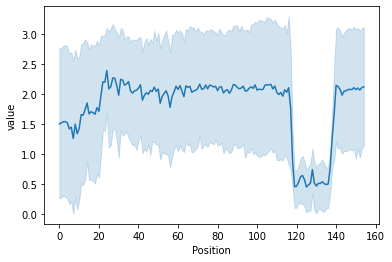

In [112]:
sns.lineplot(data=random_plot_data, x="Position", y="value")

<AxesSubplot:xlabel='Position', ylabel='value'>

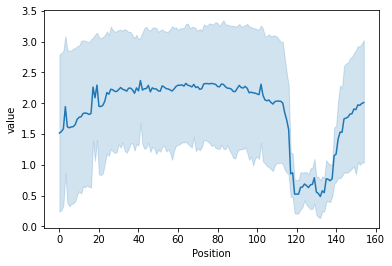

In [108]:
sns.lineplot(data=uniform_plot_data, x="Position", y="value")

<AxesSubplot:xlabel='Position', ylabel='value'>

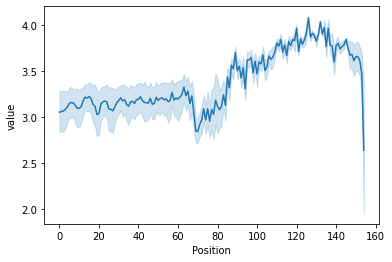

In [101]:
sns.lineplot(data=plot_data, x="Position", y="value")

In [ ]:
g = sns.relplot(data = df_monthly, x = "YM", y = "PM2.5",
                col = "District", hue = "District",
                kind = "line", palette = "Spectral",   
                linewidth = 4, zorder = 5,
                col_wrap = 5, height = 3, aspect = 1.5, legend = False
               )

#add text and silhouettes
for time, ax in g.axes_dict.items():
    ax.text(.1, .85, time,
            transform = ax.transAxes, fontweight="bold"
           )
    sns.lineplot(data = df_monthly, x = "YM", y = "PM2.5", units="District",
                 estimator = None, color= ".7", linewidth=1, ax=ax
                )

ax.set_xticks('')
g.set_titles("")
g.set_axis_labels("", "PM2.5")
g.tight_layout()

In [92]:
sdata_evolve.seqsm[f"slide_{name}"]

array([[2.6439855, 2.659272 , 2.6622267, ..., 3.31642  , 3.0157938,
        1.6532229],
       [3.3115418, 3.3178172, 3.3282354, ..., 3.8222067, 3.75958  ,
        3.6373172],
       [2.6386747, 2.6539395, 2.656894 , ..., 3.31642  , 3.0157938,
        1.6532229],
       ...,
       [3.5437565, 3.549221 , 3.560234 , ..., 3.9278746, 3.909657 ,
        3.8548982],
       [2.9620597, 2.9507833, 2.9262226, ..., 3.42605  , 3.2785563,
        1.1198375],
       [3.2087564, 3.2123873, 3.2193143, ..., 3.8392198, 3.804155 ,
        3.6722636]], dtype=float32)

In [ ]:
eu.preprocessing.decode_DNA_seq(sdata_evolve.ohe_seqs[9])

'ACAAAAGCTGTAACGAGTCACTAGGCGGCAAAGAGCCGTATGGCAATTCCATGACGTTTGGAATCACTCTAGACAGGGCGTCACCCGGTCAGCACGACTTATGGAAACGTTTTCGGAGCAACTTGTCATCCATATAAATACAACGCGATGAGTGGTTAGCGGCAAAGTTA'

In [55]:
eu.interpret.evolve_sdata(
    model,
    sdata_evolve,
    rounds=3
)
eu.interpret.evolve_sdata(
    model,
    sdata_evolve,
    rounds=5
)
eu.interpret.evolve_sdata(
    model,
    sdata_evolve,
    rounds=10
)

cuda


Evolving seqs:   0%|          | 0/310 [00:00<?, ?it/s]

cuda


Evolving seqs:   0%|          | 0/310 [00:00<?, ?it/s]

cuda


Evolving seqs:   0%|          | 0/310 [00:00<?, ?it/s]

In [58]:
sdata_evolve

SeqData object with = 310 seqs
seqs = (310,)
names = (310,)
rev_seqs = None
ohe_seqs = (310, 170, 4)
ohe_rev_seqs = None
seqs_annot: 'target', 'original_scores', 'evolved_3_scores', 'evolved_5_scores', 'evolved_10_scores'
pos_annot: None
seqsm: None
uns: None

# Double check filter instantiation

In [163]:
# Grab the dataset
sdata_leaf = eu.dl.read(os.path.join(eu.settings.dataset_dir, "leaf_processed_test.h5sd"))

In [164]:
# Instantiate new model with known motifs
new_model = eu.models.load_config("Hybrid", os.path.join(eu.settings.config_dir, "ssHybrid.yaml"))
eu.models.base.init_weights(new_model)
conv_mod = next(new_model.convnet.modules())
first_conv = conv_mod.module[0]
filters = first_conv.weight.data

In [165]:
filters[0]

tensor([[ 0.0590, -0.0047, -0.0945, -0.1325, -0.1363,  0.0462,  0.0341,  0.1250,
          0.0816, -0.1141,  0.1108,  0.0966,  0.1316],
        [ 0.1174,  0.0794, -0.0357,  0.0366, -0.0030, -0.0381, -0.0552, -0.0837,
         -0.1032,  0.1003, -0.1110, -0.0493,  0.1123],
        [ 0.1224,  0.0607,  0.1385,  0.0370, -0.1384,  0.0313, -0.1021,  0.1273,
          0.0660, -0.1016,  0.0510,  0.0750, -0.0122],
        [ 0.1137, -0.1342,  0.0080, -0.0679,  0.0329,  0.0812, -0.0616,  0.0528,
          0.1033,  0.0796, -0.0296,  0.0738, -0.0579]])

In [166]:
from eugene.utils._motif import _create_kernel_matrix

In [167]:
core_promoter_elements = eu.utils.MinimalMEME(os.path.join(eu.settings.dataset_dir, 'CPEs.meme'))
tf_groups = eu.utils.MinimalMEME(os.path.join(eu.settings.dataset_dir, 'TF-clusters.meme'))
all_motifs = {**core_promoter_elements.motifs, **tf_groups.motifs}

In [171]:
_create_kernel_matrix((256, 4, 13), all_motifs, convert_to_pwm=True)[0].T

tensor([[0.5100, 1.5060, 0.4780, 1.5060],
        [0.6300, 1.5940, 0.7960, 0.9820],
        [0.9960, 1.2120, 0.7880, 1.0040],
        [0.4940, 2.6200, 0.3020, 0.5820],
        [0.0400, 0.0080, 0.0080, 3.9440],
        [3.8720, 0.0000, 0.0000, 0.1280],
        [0.0080, 0.0560, 0.0240, 3.9120],
        [3.9680, 0.0000, 0.0080, 0.0240],
        [2.6120, 0.0480, 0.0080, 1.3320],
        [3.8960, 0.0000, 0.0320, 0.0720],
        [1.3640, 0.1120, 0.1440, 2.3820],
        [2.7820, 0.3260, 0.4780, 0.4140],
        [0.5020, 1.7280, 1.2660, 0.5020]])

In [174]:
_create_kernel_matrix((256, 4, 13), all_motifs, convert_to_pwm=False)[0].T

tensor([[0.1275, 0.3765, 0.1195, 0.3765],
        [0.1575, 0.3985, 0.1990, 0.2455],
        [0.2490, 0.3030, 0.1970, 0.2510],
        [0.1235, 0.6550, 0.0755, 0.1455],
        [0.0100, 0.0020, 0.0020, 0.9860],
        [0.9680, 0.0000, 0.0000, 0.0320],
        [0.0020, 0.0140, 0.0060, 0.9780],
        [0.9920, 0.0000, 0.0020, 0.0060],
        [0.6530, 0.0120, 0.0020, 0.3330],
        [0.9740, 0.0000, 0.0080, 0.0180],
        [0.3410, 0.0280, 0.0360, 0.5955],
        [0.6955, 0.0815, 0.1195, 0.1035],
        [0.1255, 0.4320, 0.3165, 0.1255]])

In [176]:
from eugene.models._initialize import init_from_motifs

In [177]:
layer_name, kernel_name, kernel_number, module_number = "convnet", None, None, 0

In [188]:
init_from_motifs(
    new_model, 
    all_motifs, 
    module_name=layer_name,
    module_number=module_number,
    kernel_name=kernel_name,
    kernel_number=kernel_number,
    convert_to_pwm=False
)

In [189]:
conv_mod = next(new_model.convnet.modules())
first_conv = conv_mod.module[0]
filters = first_conv.weight.data

In [190]:
filters[0].T

tensor([[0.1275, 0.3765, 0.1195, 0.3765],
        [0.1575, 0.3985, 0.1990, 0.2455],
        [0.2490, 0.3030, 0.1970, 0.2510],
        [0.1235, 0.6550, 0.0755, 0.1455],
        [0.0100, 0.0020, 0.0020, 0.9860],
        [0.9680, 0.0000, 0.0000, 0.0320],
        [0.0020, 0.0140, 0.0060, 0.9780],
        [0.9920, 0.0000, 0.0020, 0.0060],
        [0.6530, 0.0120, 0.0020, 0.3330],
        [0.9740, 0.0000, 0.0080, 0.0180],
        [0.3410, 0.0280, 0.0360, 0.5955],
        [0.6955, 0.0815, 0.1195, 0.1035],
        [0.1255, 0.4320, 0.3165, 0.1255]])

In [192]:
filters[255].T

tensor([[ 0.0070, -0.0354,  0.0260, -0.0088],
        [ 0.0310, -0.0120,  0.0170, -0.0358],
        [-0.0272,  0.0005, -0.0183,  0.0015],
        [-0.0167, -0.0129, -0.0247,  0.0336],
        [-0.0369, -0.0213, -0.0112,  0.0201],
        [ 0.0100, -0.0233, -0.0012, -0.0071],
        [-0.0009,  0.0285,  0.0396,  0.0334],
        [-0.0002,  0.0114, -0.0078, -0.0365],
        [ 0.0116, -0.0317,  0.0084, -0.0010],
        [ 0.0373,  0.0307, -0.0186, -0.0192],
        [-0.0196,  0.0314,  0.0415,  0.0179],
        [-0.0082, -0.0410, -0.0106,  0.0169],
        [ 0.0093, -0.0112,  0.0202, -0.0193]])

In [193]:
# Generate pfm
eu.interpret.generate_pfms(new_model, sdata_leaf)

No transforms given, assuming just need to tensorize).


Getting maximial activating seqlets:   0%|          | 0/55 [00:00<?, ?it/s]

Getting PFMs from filters:   0%|          | 0/256 [00:00<?, ?it/s]

In [195]:
sdata_leaf.uns["pfms"][0]

,A,C,G,T
0,55409.0,49825.0,32338.0,71181.0
1,61219.0,51084.0,35292.0,61158.0
2,63183.0,45989.0,34812.0,64769.0
3,60626.0,66720.0,28409.0,52998.0
4,45633.0,29144.0,22717.0,111259.0
5,116649.0,28465.0,23287.0,40352.0
6,46890.0,29821.0,24545.0,107497.0
7,121881.0,28639.0,22592.0,35641.0
8,93088.0,30764.0,25043.0,59858.0
9,125348.0,26281.0,21573.0,35551.0


In [196]:
sdata_leaf.uns["pfms"][255]

,A,C,G,T
0,6625.0,752.0,8896.0,3395.0
1,11955.0,1648.0,5391.0,674.0
2,2722.0,5739.0,2828.0,8379.0
3,2214.0,1973.0,900.0,14581.0
4,1142.0,2176.0,3537.0,12813.0
5,7961.0,1696.0,4870.0,5141.0
6,1698.0,4167.0,6922.0,6881.0
7,7060.0,7584.0,3583.0,1441.0
8,8298.0,1045.0,5314.0,5011.0
9,11234.0,6464.0,816.0,1154.0


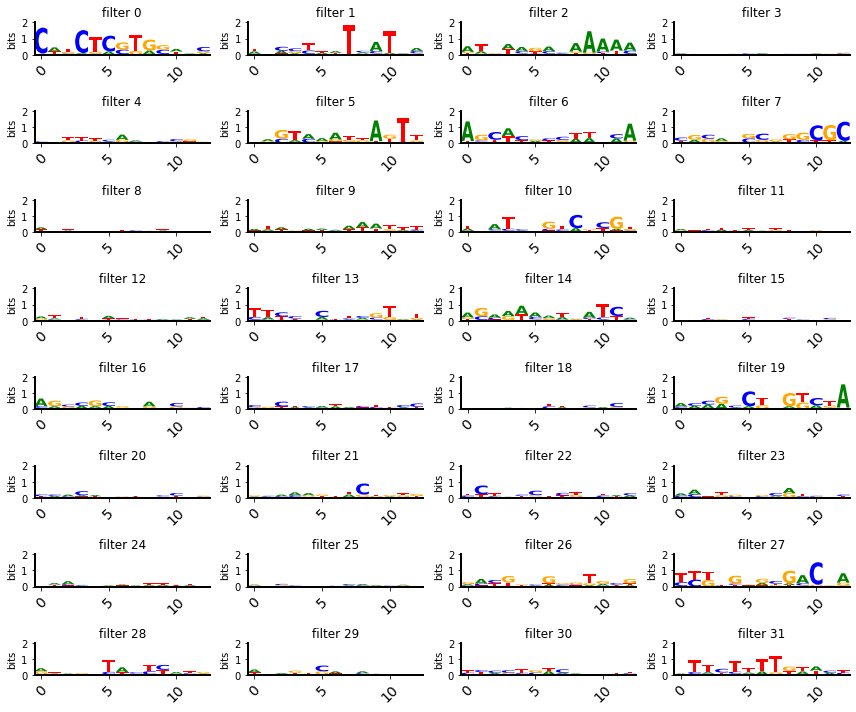

In [129]:
eu.pl.lm_multifilter_viz(
    sdata_leaf,
    filter_ids=list(sdata_leaf.uns["pfms"].keys())[200:232],
    num_rows=8,
    num_cols=4,
    titles=[f"filter {i}" for i in range(32)],
)

In [197]:
# Load in a trained model
leaf_model_file = glob.glob(os.path.join(eu.settings.logging_dir, "ssHybrid", f"leaf_trial_5", "checkpoints", "*"))[0]
leaf_model = eu.models.Hybrid.load_from_checkpoint(leaf_model_file)
leaf_model

Hybrid(
  (hp_metric): R2Score()
  (convnet): BasicConv1D(
    (module): Sequential(
      (0): Conv1d(4, 256, kernel_size=(13,), stride=(1,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.3, inplace=False)
      (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Conv1d(256, 256, kernel_size=(13,), stride=(1,))
      (6): ReLU()
      (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Dropout(p=0.3, inplace=False)
      (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): Conv1d(256, 256, kernel_size=(13,), stride=(1,))
      (11): ReLU()
      (12): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (13): Dropout(p=0.3, inplace=False)
      (14): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (recurren

In [198]:
conv_mod = next(leaf_model.convnet.modules())
first_conv = conv_mod.module[0]
filters = first_conv.weight.data

In [200]:
filters[0].T

tensor([[ 3.2627e-01,  1.5911e+00,  5.4844e-01,  1.4227e+00],
        [ 6.6034e-01,  1.5924e+00,  7.2295e-01,  9.1231e-01],
        [ 7.8357e-01,  1.2437e+00,  9.1353e-01,  9.5777e-01],
        [ 4.0481e-01,  2.7814e+00,  2.1773e-01,  4.1811e-01],
        [-1.0975e-01,  9.3960e-03,  1.5325e-02,  3.9597e+00],
        [ 3.8955e+00,  4.3094e-02, -9.1144e-02,  8.5265e-03],
        [-1.7021e-01,  1.0885e-02,  9.6944e-02,  3.9238e+00],
        [ 3.9925e+00,  2.6274e-02,  1.9689e-02, -1.6815e-01],
        [ 2.4412e+00,  5.3457e-02,  3.6463e-02,  1.3546e+00],
        [ 3.8843e+00,  1.7390e-03,  5.2349e-02, -5.7627e-02],
        [ 1.2135e+00,  1.0796e-01,  9.6406e-02,  2.4594e+00],
        [ 2.8155e+00,  3.3877e-01,  3.6530e-01,  3.5833e-01],
        [ 4.2649e-01,  1.7005e+00,  1.2508e+00,  5.0175e-01]])

In [203]:
filters[255].T

tensor([[-0.1851,  0.0514, -0.2105,  0.1390],
        [ 0.1426, -0.1587, -0.1224, -0.0454],
        [-0.0184, -0.0695, -0.1174,  0.0626],
        [ 0.0420, -0.1915,  0.0168,  0.0051],
        [ 0.0661, -0.1508, -0.1956,  0.0706],
        [ 0.0320, -0.0663,  0.0441, -0.0540],
        [-0.0427,  0.0157, -0.0246, -0.0664],
        [-0.0134, -0.0456,  0.0103, -0.0557],
        [-0.0599, -0.0182,  0.0355,  0.0095],
        [-0.0372, -0.0091,  0.0195, -0.0083],
        [-0.0394,  0.0315, -0.0294, -0.0676],
        [-0.0689,  0.0186,  0.0477, -0.1005],
        [-0.0643,  0.0027, -0.0691, -0.0221]])

In [ ]:
# TODO: turn into a function that plots all the filters in groups specified by user
for i in range(8):
    start_filter = i*32
    end_filter = (i*32) + 32
    print(f"Plotting and saving filters {start_filter+1}-{end_filter}")
    eu.pl.lm_multifilter_viz(
        sdata,
        filter_ids=list(sdata.uns["pfms"].keys())[start_filter:end_filter],
        num_rows=8,
        num_cols=4,
        titles=[f"filter {i}" for i in range(32)],
    )

---

# Scratch

In [ ]:
import logomaker as lm
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

def lm_seq_track(
    sdata,
    seq_id=None,
    uns_key=None,
    highlights: list = [],
    highlight_colors: list = ["lavenderblush", "lightcyan", "honeydew"],
    ylabel = "Saliency",
    title="",
    return_ax: bool = False,
    save=None,
    **kwargs
):
    if isinstance(highlight_colors, str):
        highlight_colors = [highlight_colors] * len(highlights)

    # Get the sequence and annotations
    seq_idx = np.where(sdata.seqs_annot.index == seq_id)[0][0]
    seq = sdata.seqs[seq_idx]
    imp_scores = sdata.uns[uns_key][seq_idx] if uns_key in sdata.uns.keys() else None
    viz_seq = pd.DataFrame(imp_scores.T, columns=["A", "C", "G", "T"])
    viz_seq.index.name = "pos"
    y_max = np.max(viz_seq.values)
    y_min = np.min(viz_seq.values)
    nn_logo = lm.Logo(
        viz_seq,
        **kwargs
    )

    # style using Logo methods
    nn_logo.style_spines(visible=False)
    nn_logo.style_spines(spines=['left'], visible=True, bounds=[y_min, y_max])

    # style using Axes methods
    nn_logo.ax.set_xlim([0, len(viz_seq)])
    nn_logo.ax.set_xticks([])
    nn_logo.ax.set_ylim([y_min, y_max])
    nn_logo.ax.set_ylabel(ylabel)
    nn_logo.ax.set_title(title)
    for i, highlight in enumerate(highlights):
        nn_logo.highlight_position_range(pmin=highlight[0], pmax=highlight[1], color=highlight_colors[i])
    if return_ax:
        return nn_logo.ax
    if save is not None:
        plt.savefig(save)


def lm_multiseq_track(
    sdata,
    seq_ids: list,
    uns_keys: str = None,
    ylabels: list = None,
    width=None,
    height=None,
    return_axes: bool = False,
    save: str = None,
    **kwargs
):
    if isinstance(seq_ids, str):
        seq_ids = [seq_ids]
    if isinstance(uns_keys, str):
        uns_keys = [uns_keys]
    if isinstance(ylabels, str):
        ylabels = [ylabels]
    ylabels = ylabels if ylabels is not None else ["Importance Score"] * len(uns_keys)
    fig_width = len(seq_ids) * int(170 / 20) if width is None else width # make each sequence width proportional to its length and multiply by the number of sequences
    fig_height = len(uns_keys)*4 if height is None else height # make each sequence height proportional to the number of uns_keys
    _, ax = plt.subplots(len(uns_keys), len(seq_ids), figsize=(fig_width, fig_height))
    for i, uns_key in tqdm(enumerate(uns_keys), desc=f"Importance values", position=0):
        for j, seq_id in enumerate(seq_ids):
            lm_seq_track(
                sdata,
                seq_id=seq_id,
                uns_key=uns_key,
                ax=ax.flatten()[i*len(seq_ids)+j],
                ylabel=ylabels[i],
                title=seq_id,
                save=None,
                **kwargs
            )

    plt.tight_layout()
    if return_axes:
        return ax
    if save is not None:
        plt.savefig(save)

In [ ]:
import matplotlib.pyplot as plt
from eugene.plotting._seq import _plot_seq_logo
from tqdm.auto import tqdm
uns_keys = [method + "_imps" for method in ["InputXGradient", "DeepLift", "GradientSHAP", "NaiveISM"]]
ylabels = ["InputXGradient", "DeepLift", "GradientSHAP", "NaiveISM"]
seq_id = sdata.names[:2]
if isinstance(seq_id, str):
    seq_id = [seq_id]
if isinstance(uns_keys, str):
    uns_keys = [uns_keys]
seq_idx = np.where(sdata.seqs_annot.index.isin(seq_id))[0]
seqs = sdata.seqs[seq_idx]
print(seq_id, uns_keys, seq_idx, seqs)
fig_width = len(seq_id) * int(len(seqs[0]) / 20) # make each sequence width proportional to its length and multiply by the number of sequences
fig_height = len(uns_keys)*6
_, ax = plt.subplots(len(uns_keys), len(seq_id), figsize=(fig_width, fig_height))
for i, uns_key in tqdm(enumerate(uns_keys), desc=f"Importance values", position=0):
    for j, seq in tqdm(enumerate(seqs), desc=f"Plotting sequence", position=1):
        imp_scores = sdata.uns[uns_key][seq_idx[j]] if uns_key in sdata.uns.keys() else None
        _plot_seq_logo(
            ax.flatten()[i*len(seq_id)+j],
            seq,
            imp_scores=imp_scores,
            ylab=ylabels[i],
        )
        if i == 0:
            print(j*len(uns_keys))
            ax.flatten()[i*len(seq_id)+j].set_title(seq_id[j], fontsize=18, weight="bold")
plt.tight_layout()

In [ ]:
cpm = seqlogo.CompletePm(pfm=sdata_leaf.uns["pfms"][0])
print(cpm)
scaled_cpm = cpm.ppm.multiply(cpm.ic, axis=0)
logo = seqlogo.seqlogo(cpm, ic_scale=True, format="png")
display(logo)

In [ ]:
info_mat = logomaker.transform_matrix(pfm, 
                                      from_type='counts', 
                                      to_type='information')                                      
fig, ax = plt.subplots(num_rows, num_cols, figsize=(12,10))
for i in range(num_rows):
    for j in range(num_cols):
        filter_id = filter_ids[i*num_cols+j]
        pfm=sdata_leaf.uns["pfms"][filter_id]
        info_mat = logomaker.transform_matrix(
            pfm, 
            from_type='counts', 
            to_type='information')
        logo = logomaker.Logo(
            info_mat,
            font_name = 'Arial Rounded MT Bold',
            ax=ax[i,j])
        logo.style_xticks(spacing=5, anchor=25, rotation=45, fmt='%d', fontsize=14)
        logo.style_spines(visible=False)
        logo.style_spines(spines=['left','bottom'], visible=True, linewidth=2)

        logo.ax.set_ylim([0, 2])
        logo.ax.set_yticks([0, 1, 2])
        logo.ax.set_yticklabels(['0', '1', '2'])
        logo.ax.set_ylabel('bits')
plt.tight_layout()
plt.savefig('../../_output/jores21/pfms.pdf')

In [ ]:
fig, ax = plt.subplots(num_rows, num_cols, figsize=(12,10))
for i in range(num_rows):
    for j in range(num_cols):
        ax[i,j].imshow(imread(os.path.join(eu.settings.output_dir, "fig", f"leaf_filter_{i*num_cols+j}.png")))
        #ax[i,j].axis('off')
#plt.savefig(os.path.join(eu.settings.output_dir, "fig", "leaf_filters.pdf"))

In [ ]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

def showImagesHorizontally(list_of_files):
    fig = figure(figsize=(20,10))
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = imread(list_of_files[i])
        imshow(image,cmap='Greys_r')
        axis('off')

import glob
showImagesHorizontally(glob.glob("../../_output/jores21/fig/*filter*.png"))

In [ ]:
for filter_id in filter_ids:
    pfm=sdata_leaf.uns["pfms"][filter_id]
    cpm = seqlogo.CompletePm(pfm=pfm)
    logo = seqlogo.seqlogo(
        cpm, 
        ic_scale=True, 
        format="png", 
        size="xlarge",
        filename=os.path.join(eu.settings.output_dir, "fig", f"leaf_filter_{filter_id}.png")
    )
    

No importance scores given, outputting just sequence
No importance scores given, outputting just sequence


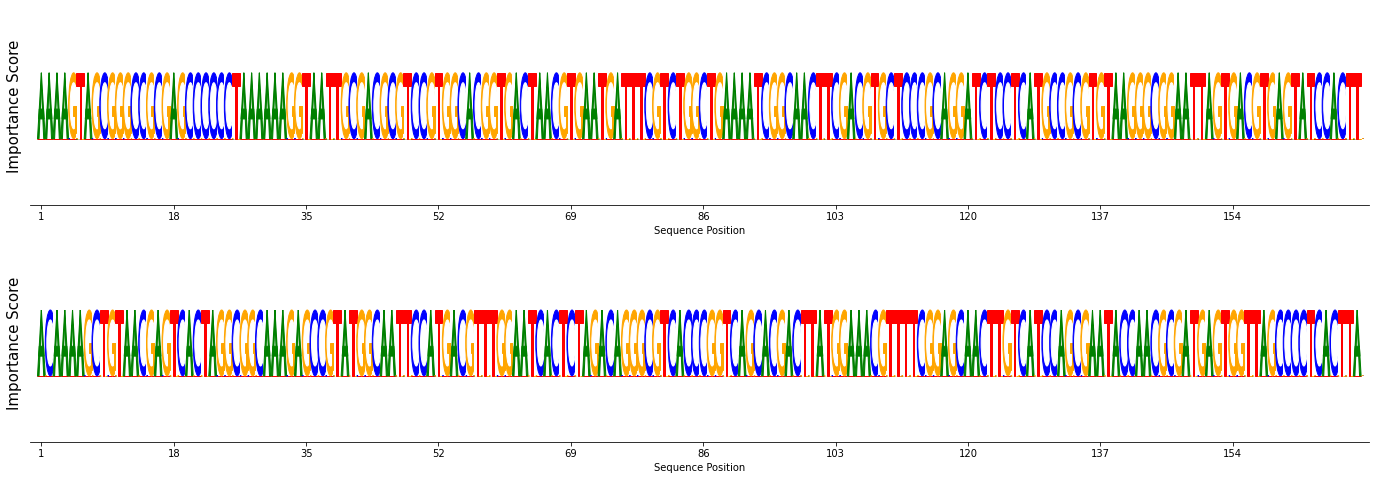

In [ ]:
from eugene.plotting._seq import _plot_seq_logo
fig, ax = plt.subplots(2, 1, figsize=(24, 8))
_plot_seq_logo(ax[1], sdata_evolve.seqs[10])
_plot_seq_logo(ax[0], eu.pp.decode_DNA_seq(evolved_seq[0]))